# Importiere Daten


In [2]:
import numpy as np
import pandas as pd
#import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os

## Funktionen definieren

In [3]:
def linear_reg(x, m, t):
    return m*x + t

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [4]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [5]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [6]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)

## Differenz berechnen

In [7]:
TMin_Lat = TMin.sel(lat = slice(-90, 90)).mean('lon')
TMax_Lat = TMax.sel(lat = slice(-90, 90)).mean('lon')
TAvg_Lat = TAvg.sel(lat = slice(-90, 90)).mean('lon')

In [8]:
angles_in_degrees = TMin_Lat['lat']

# Convert degrees to radians (cos function in numpy works with radians)
angles_in_radians = np.radians(angles_in_degrees)

cosine_values = np.cos(angles_in_radians)

TMin_Lat.tmn
weight_fac = len(cosine_values)/np.sum(cosine_values)

TMin_Lat_temp = TMin_Lat*cosine_values * weight_fac 
TMax_Lat_temp = TMax_Lat*cosine_values * weight_fac
TAvg_Lat_temp = TAvg_Lat*cosine_values * weight_fac

In [9]:
TMin_Lat_tot = TMin_Lat_temp.mean('lat')
TMax_Lat_tot = TMax_Lat_temp.mean('lat')
TAvg_Lat_tot = TAvg_Lat_temp.mean('lat')

In [10]:
# TMin_Lat = TMin.mean('lon')
# TMax_Lat = TMax.mean('lon')
# TAvg_Lat = TAvg.mean('lon')

In [11]:
time_values = TMax['time'].values

In [12]:
# TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
# TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
# TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')

In [13]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [14]:
monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()
monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()


In [15]:
monthly_mean_DTR['month'] = monthly_mean_DTR['time'].dt.month
monthly_mean_TAvg['month'] = monthly_mean_TAvg['time'].dt.month

## Generiere Unterteilungen des Nordpols (Ringe)

In [16]:
# Creating dict with different averages
TAvg_mean_dict = {}

slices = [(66, 70), (70, 75), (75, 80), (80, 84), (70, 84)]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = TAvg_Lat.tmp.sel(lat=slice(start, end)).mean('lat')
    TAvg_mean_dict[f'{start}-{end}'] = sliced_data

# Creating dict with different averages
DTR_mean_dict = {}

slices = [(66, 70), (70, 75), (75, 80), (80, 84)]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = temperature_difference_Lat.sel(lat=slice(start, end)).mean('lat')
    DTR_mean_dict[f'{start}-{end}'] = sliced_data


Plotten

In [17]:
# # Extract the keys and values from TAvg_mean_dict and DTR_mean_dict
# ta_keys = list(TAvg_mean_dict.keys())

# legend_handles = []

# for i in ta_keys:
#     plt.scatter(TAvg_mean_dict[i], DTR_mean_dict[i], label = i + '°N' )

# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')


# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.png')
# plt.legend()

# plt.tight_layout()
# plt.show()


## Plots Yearly trends

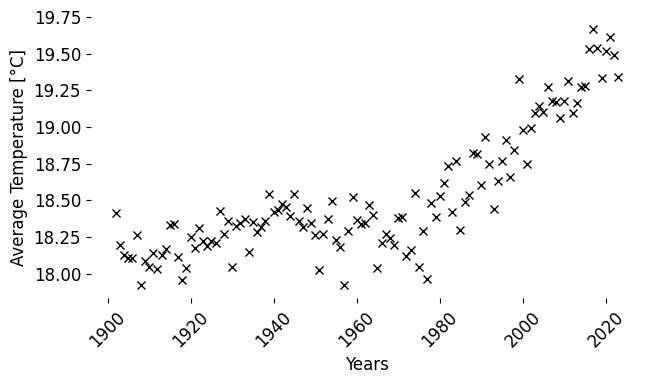

In [25]:
yearly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='Y').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Average Temperature [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Add gridlines
#ax.grid(True)

# Add a legend
#ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

#plt.xlim(pd.to_datetime('1960',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()



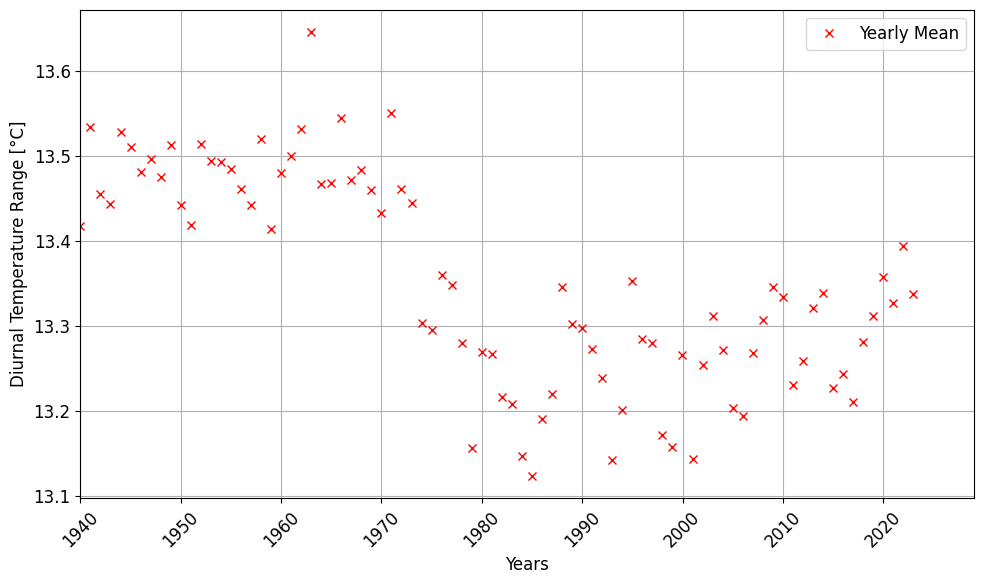

In [19]:
yearly_mean_DTR = temperature_difference_Pol.resample(time='Y').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Diurnal Temperature Range [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.xlim(pd.to_datetime('1940',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure

# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.png')
plt.show()



In [26]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Create a figure and axis object
# fig, ax1 = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# # Plot the data with the first y-axis
# ax1.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Average Temperature')
# ax1.set_xlabel('Years')
# ax1.set_ylabel('Average Temperature [°C]', color='black')

# # Create a second y-axis and plot data with it
# ax2 = ax1.twinx()
# ax2.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='.', linestyle='',  color='red', label='DTR')
# ax2.set_ylabel('Diurnal Temperature Range [°C]', color='r')


# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(False)

# ax2.spines['top'].set_visible(False)
# # ax2.spines['right'].set_visible(False)
# # ax2.spines['bottom'].set_visible(False)
# # ax2.spines['left'].set_visible(False)

# plt.xlim(pd.to_datetime('1970',))
# ax2.set_ylim(7.15,7.6)

# # Add a legend
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

# # Show the plot
# plt.tight_layout() 
# plt.show()


In [27]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Create a figure with two subplots (one for each plot)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17 / 2.54, 8))  # 2 rows, 1 column

# # Plot the data in the first subplot
# ax1.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='', color='black', label='Average Temperature')
# ax1.set_ylabel('Average Temperature [°C]', color='black')

# # Plot the data in the second subplot
# ax2.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='.', linestyle='', color='red', label='DTR')
# ax2.set_xlabel('Years')
# ax2.set_ylabel('Diurnal Temperature Range [°C]')

# # Hide x-axis ticks and labels for the first subplot
# # ax1.set_xticks([])
# # ax2.set_yticks([])

# # Set the x-axis limit for both subplots
# ax1.set_xlim(pd.to_datetime('1970',))
# ax2.set_xlim(pd.to_datetime('1970',))

# # Set the y-axis limits for the second subplot
# #ax2.set_ylim(7.15, 7.6)

# # Add legends to both subplots
# # ax1.legend(loc='best')
# # ax2.legend(loc='best')

# # Remove the top and right spines for both subplots
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)


# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


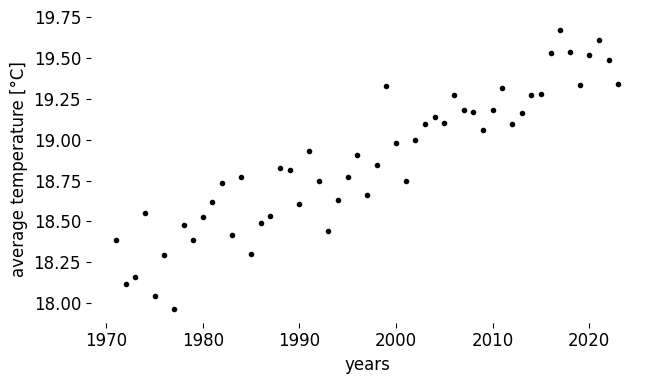

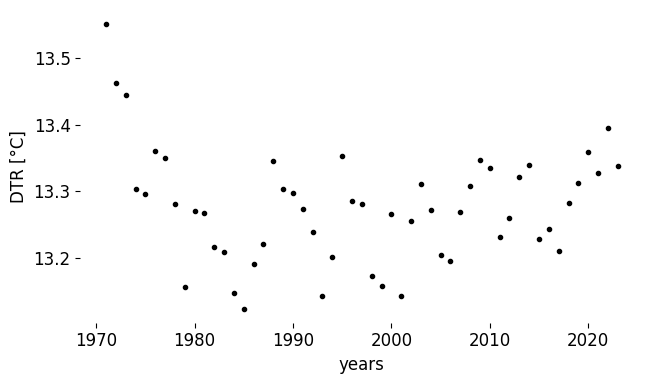

In [62]:
startdate = '1970'

yearly_mean_TAvg_after_1970 = yearly_mean_TAvg.sel(time=yearly_mean_TAvg['time'] >= pd.to_datetime(startdate))

# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 4))

# Plot the data for the first plot
ax1.plot(yearly_mean_TAvg_after_1970.time, yearly_mean_TAvg_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('years')
ax1.set_ylabel('average temperature [°C]', color='black')

# Set the x-axis limit for the first plot
#ax1.set_xlim(pd.to_datetime('1970',))

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
lines1, labels1 = ax1.get_legend_handles_labels()
#ax1.legend(lines1, labels1, loc='best')

# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_TAvg_yearly1970_global_'+str(startdate)+ '.pdf')
plt.savefig('CRU_data_TAvg_yearly1970_global_'+str(startdate)+ '.png',dpi = 300)
plt.show()


yearly_mean_DTR_after_1970 = yearly_mean_DTR.sel(time=yearly_mean_DTR['time'] >= pd.to_datetime(startdate))
# Create the second plot
fig2, ax2 = plt.subplots(figsize=(17 / 2.54, 4))

# Plot the data for the second plot
ax2.plot(yearly_mean_DTR_after_1970.time, yearly_mean_DTR_after_1970, marker='.', linestyle='', color='black', label='DTR')
ax2.set_xlabel('years')
ax2.set_ylabel('DTR [°C]')

# Set the x-axis limit for the second plot
#ax2.set_xlim(pd.to_datetime('1970',))

# Set the y-axis limits for the second plot
#ax2.set_ylim(7.15, 7.6)

# Remove the top and right spines for the second plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add a legend to the second plot
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines2, labels2, loc='best')

# Show the second plot
plt.tight_layout()
plt.savefig('CRU_data_DTR_yearly1970_global_'+str(startdate)+ '.pdf')
plt.savefig('CRU_data_DTR_yearly1970_global_'+str(startdate)+ '.png',dpi = 300)
plt.show()


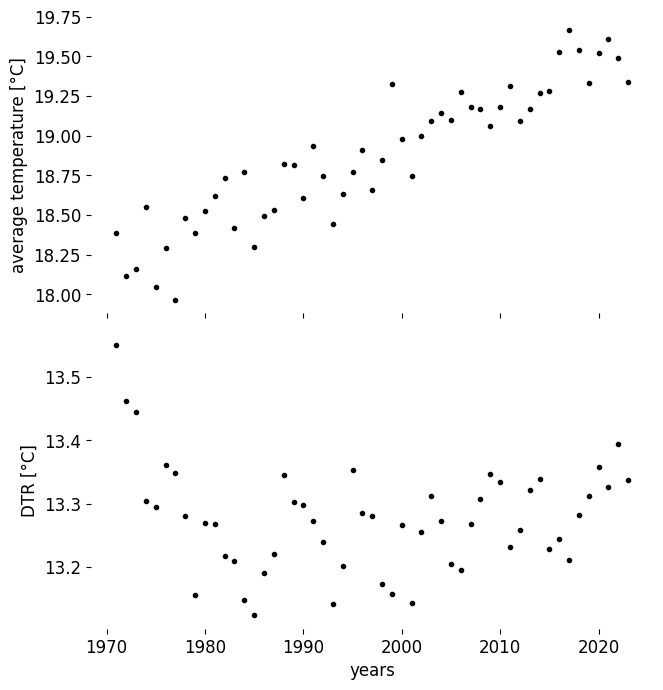

In [63]:
# Assuming 'yearly_mean_TAvg' and 'yearly_mean_DTR' are already defined

# Filter data for the first plot
yearly_mean_TAvg_after_1970 = yearly_mean_TAvg.sel(time=yearly_mean_TAvg['time'] >= pd.to_datetime(startdate))

# Filter data for the second plot
yearly_mean_DTR_after_1970 = yearly_mean_DTR.sel(time=yearly_mean_DTR['time'] >= pd.to_datetime(startdate))

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17 / 2.54, 7))

# Plot the data for the first subplot
ax1.plot(yearly_mean_TAvg_after_1970.time, yearly_mean_TAvg_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_ylabel('average temperature [°C]')
ax1.set_xticklabels([])  # Remove x-axis labels for the first subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Plot the data for the second subplot
ax2.plot(yearly_mean_DTR_after_1970.time, yearly_mean_DTR_after_1970, marker='.', linestyle='', color='black', label='DTR')
ax2.set_xlabel('years')
ax2.set_ylabel('DTR [°C]')
#ax2.set_ylim(7.15, 7.45)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save or show the plot
plt.savefig('combined_plot_yearly'+str(startdate)+'nomarker_global.pdf')
plt.savefig('combined_plot_yearly'+str(startdate)+'nomarker_global.png', dpi=300)
plt.show()
